<a href="https://colab.research.google.com/github/CrMessiSuriJr/ai-face-recognition/blob/master/resnet_implementation_leaf_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import datasets, models
import os
import random
import shutil
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt

!pip install captum
import captum.attr as captum_attr
from captum.attr import GuidedGradCam

!pip install lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from lime.lime_image import LimeImageExplainer

from sklearn.manifold import TSNE

In [2]:
# Define data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.CenterCrop(224),     # Center crop to 224x224 pixels
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [3]:
drive.mount('/content/drive')

# Set the path to your Kaggle API key in Google Drive
kaggle_api_key_path = '/content/kaggle/kaggle.json'

# Copy the Kaggle API key to the required directory
!mkdir -p ~/.kaggle
!cp "$kaggle_api_key_path" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/drive


In [4]:
import kaggle

# Replace 'your_dataset_folder' with the Kaggle dataset name
dataset_name = 'emmarex/plantdisease'

# Define the dataset path
dataset_path = '/content/drive/MyDrive/'

# Download the dataset using Kaggle API
#kaggle.api.dataset_download_files(dataset_name, unzip=True, path= dataset_path)  # Download and unzip the dataset to the './data' directory



In [36]:
# Define the ratio for the train-test split
split_ratio = 0.7  # 70% for training, 30% for testing

# Specify the path to your dataset on Google Drive
drive_dataset_path = '/content/drive/My Drive/PlantVillage'

# List all the class folders in your dataset directory
class_folders = os.listdir(drive_dataset_path)

# Create train and test directories if they don't exist
train_dir = '/content/train'
test_dir = '/content/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# Function to check if an image can be opened without errors
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except Exception as e:
        return False

# Iterate through each class folder
for class_folder in class_folders:
    class_path = os.path.join(drive_dataset_path, class_folder)

    # List all the image files in the current class folder
    all_files = os.listdir(class_path)

    # Randomly shuffle the list of files
    random.shuffle(all_files)

    # Calculate the number of files for training and testing within the current class
    num_total_files = len(all_files)
    num_train_files = int(split_ratio * num_total_files)
    num_test_files = num_total_files - num_train_files

    # Create train and test subdirectories within the class folder
    class_train_dir = os.path.join(train_dir, class_folder)
    class_test_dir = os.path.join(test_dir, class_folder)
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_test_dir, exist_ok=True)

    # Move the first num_train_files files to the train subdirectory and the rest to the test subdirectory
    for i, file_name in enumerate(all_files):
        source_path = os.path.join(class_path, file_name)
        if i < num_train_files and is_valid_image(source_path):
            destination_path = os.path.join(class_train_dir, file_name)
        else:
          if is_valid_image(source_path):
            destination_path = os.path.join(class_test_dir, file_name)
        shutil.copy(source_path, destination_path)

In [6]:
# Iterate through your dataset and check each image
for class_folder in class_folders:
    class_path = os.path.join(drive_dataset_path, class_folder)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        if not is_valid_image(image_path):
          print(f"Invalid image: {image_path}")

# Create ImageFolder datasets for training and testing (excluding problematic images)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define batch size and number of workers for data loading (adjust as needed)
batch_size = 32
num_workers = 4

# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# You can iterate through this train_loader in your training loop
for batch in train_loader:
    inputs, labels = batch

# Print the class names (based on folder names)
class_names = train_dataset.classes
print("Class names:", class_names)

# Print the number of samples in the training and testing sets
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight']
Number of training samples: 5642
Number of testing samples: 2421


In [7]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        # Define the ResNet architecture here (e.g., ResNet-18, ResNet-50)
        self.resnet = models.resnet50(pretrained=True)  # Use models.resnet50
        # Modify the last layer for your specific number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [8]:
# Initialize the model
num_classes = len(train_dataset.classes)
model = ResNet(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')


Epoch 1/10, Loss: 0.47468925195898715
Epoch 2/10, Loss: 0.23813197193509442
Epoch 3/10, Loss: 0.1819092193776268
Epoch 4/10, Loss: 0.1008441234165329
Epoch 5/10, Loss: 0.10954245630425459
Epoch 6/10, Loss: 0.08809691436304631
Epoch 7/10, Loss: 0.07576800798102792
Epoch 8/10, Loss: 0.09861489266846435
Epoch 9/10, Loss: 0.05825338189590112
Epoch 10/10, Loss: 0.05341937963089164


In [11]:
# Evaluation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
for batch in test_loader:
    inputs, labels = batch
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total}%')

Accuracy on test set: 96.07600165220983%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<Figure size 1000x800 with 0 Axes>

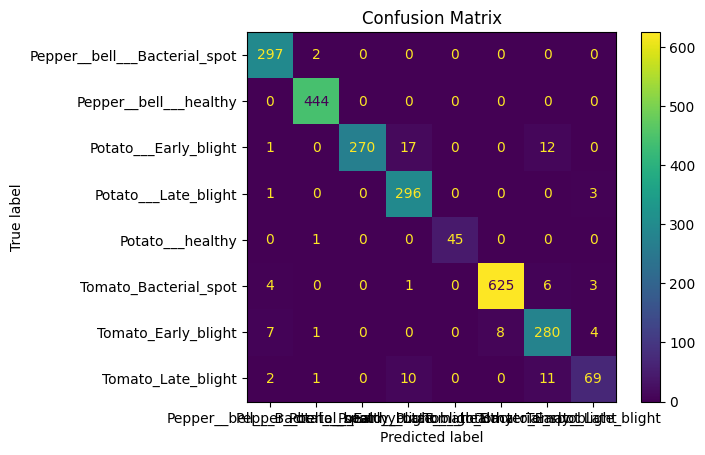

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get true labels and predicted labels
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes).plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [52]:
# Load the test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

# Define a function to compute GradCAM
def compute_gradcam(input_image, target_class):
    model.eval()
    input_image = input_image.to(device)
    target_class = torch.tensor(target_class).to(device)

    # Create a GradCAM object
    gradcam = captum_attr.GuidedGradCam(model, model.resnet.layer4[-1].conv3)

    # Compute attribution scores
    attribution = gradcam.attribute(input_image, target=target_class)

    # Detach the attribution tensor from the computation graph
    attribution = attribution.detach()

    return attribution

# Choose an image and target class index for GradCAM visualization
image, label = test_dataset[0]

# Transpose the image to [channels, height, width]
image = image.permute(1, 2, 0)

# Compute GradCAM
attribution = compute_gradcam(image.unsqueeze(0), target_class_index)

# Visualize the GradCAM heatmap
plt.figure(figsize=(8, 8))
plt.imshow(attribution.squeeze(0).cpu(), cmap='viridis')
plt.title('GradCAM Heatmap')
plt.show()


FileNotFoundError: ignored

In [47]:
# Define a function to create a Lime explainer and explain predictions
def explain_lime(image, model, num_classes):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, model.predict, top_labels=num_classes)
    return explanation

# Choose an image to explain
image, label = test_dataset[0]
explanation = explain_lime(image.numpy(), model, num_classes)

# Visualize the Lime explanation
temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='viridis')
plt.title('LIME Explanation')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: ignored

In [41]:
# Get feature representations for a subset of your data
num_samples = 1000  # Change this to your desired number of samples
features = []
labels = []

model.eval()
with torch.no_grad():
    for inputs, batch_labels in test_loader:
        inputs = inputs.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        labels.extend(batch_labels.cpu().numpy())

features = features[:num_samples]
labels = labels[:num_samples]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

# Visualize t-SNE plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('t-SNE Plot')
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


AttributeError: ignored